In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize images to match model input size
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

data = datasets.ImageFolder(root='../DL_data/PetImages', transform=transform)
train_size = int(0.7 * len(data))
val_size = int(0.15 * len(data))
test_size = len(data) - train_size - val_size
train_data, val_data, test_data = random_split(data, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [5]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
from tqdm import tqdm

# # Load pre-trained InceptionV3
# model = models.inception_v3(pretrained=True)

# # Modify the fully connected (FC) layer for 2 classes (Cat and Dog)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 2)  # 2 output classes (Cat & Dog)

# # Move model to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in tqdm(range(epochs)):
        model.train()
        train_loss, train_correct = 0, 0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)

            # For InceptionV3, use auxiliary output during training
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels).item()

        # Validation loop
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                if isinstance(outputs, tuple):
                    outputs = outputs[0]

                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels).item()

        # Calculate epoch metrics
        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)

        # Store history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        # print(f"Epoch {epoch+1}/{epochs}: "
        #       f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
        #       f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} ")

    return history

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    plt.show()

def test_model(model, test_loader):
    model.eval()
    test_correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            if isinstance(outputs, tuple):
                outputs = outputs[0]

            _, preds = torch.max(outputs, 1)
            test_correct += torch.sum(preds == labels).item()

    test_acc = test_correct / len(test_loader.dataset)
    print(f"Test Accuracy: {test_acc:.4f}")

c:\Users\nick2\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nick2\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\nick2\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 5/5 [17:20<00:00, 208.04s/it]


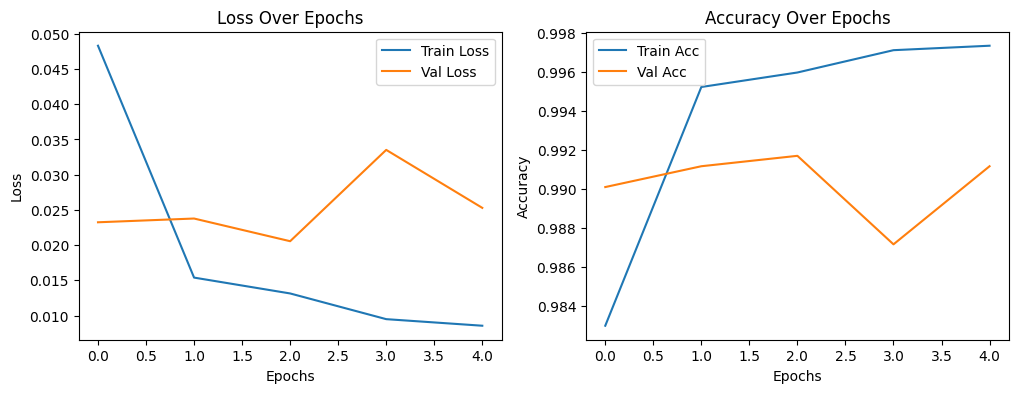

Test Accuracy: 0.9883


In [6]:
model = models.inception_v3(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 output classes (Cat & Dog)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)
plot_history(history)
test_model(model, test_loader)


I used google's inception-v3
we had enough data that within 5 epochs the model was predicting our labels with incredible accuracy.